## Getting Started

- Kaggle Competition - [siim-acr-pneumothorax-segmentation](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/overview)
- Download Data 
- Create a Pytorch Dataset and Dataloader.


### Prepare data

- Install Kaggle API
- Download Data
- Extract Data


In [1]:
!pip install -r requirements.txt -q

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


Add kaggle.json file under ~/.kaggle/

In [2]:
!kaggle datasets download -d jesperdramsch/siim-acr-pneumothorax-segmentation-data

100%|█████████████████████████████████████▉| 3.03G/3.03G [04:02<00:00, 17.4MB/s]
100%|██████████████████████████████████████| 3.03G/3.03G [04:02<00:00, 13.4MB/s]


Lets extract the data to a folder called data

In [3]:
!unzip -q siim-acr-pneumothorax-segmentation-data.zip -d data/

In [4]:
ls data/

dicom-images-test/  dicom-images-train/  pneumothorax/  train-rle.csv


In [7]:
from fastai.vision.all import *
from mask_functions import run_length_decode
import pydicom
import fastai

In [8]:
{o.__name__:o.__version__ for o in [torch,fastai,pydicom]}

{'torch': '1.8.0a0+52ea372', 'fastai': '2.3.1', 'pydicom': '2.1.2'}

In [9]:
data_path = Path('data/')
data_path.ls()

(#4) [Path('data/dicom-images-test'),Path('data/dicom-images-train'),Path('data/pneumothorax'),Path('data/train-rle.csv')]

We can observe there is a 
- dicom-images-train
- dicom-images-test

Similar structure also exists under `pneumothorax` folder. The data for the competition was not provided directly and few good souls like [Jesper](https://www.kaggle.com/jesperdramsch) made the data avaialable as simple Kaggle Datasets

On a quick look both the folders contains same data. 

In [10]:
assert len((data_path/'pneumothorax/dicom-images-train').ls())==len((data_path/'dicom-images-train').ls())


For the current experimentations, lets use the data that is available outside of `pneumothorax`

In [11]:
train_meta = pd.read_csv(data_path/'train-rle.csv')
#Column names contains blank spaces. Lets remove them
train_meta.columns = [o.strip() for o in train_meta.columns]

In [12]:
train_meta.head(3)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 1000 23 999 23 1000 22 1001 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1002 21 1002 20 1003 20 1002 21 1001 23 1000 23 999 24 999 24 999 23 999 24 999 24 998 26 996 27 995 28 995 28 994 30 993 30 993 30 993 30 993 31 992 31 992 31 992 31 992 32 990 33 990 33 990 33 991 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 992 31 993 30 993 30 993 30 993 30 994 29 994 29 994 30 993 30 994 29 994 30 993 30 993 31 993 31 992 31 992...


## Data format

The data primarily contains inputs in the form of dicom files and masks as rle (run-length-encoded) encoded values. 

Some of the images contain instances of pneumothorax (collapsed lung), which are indicated by encoded binary masks in the annotations. Some training images have multiple annotations.

If a patient image contains Pneumotherax then the rle value of the mask would look like below

```1.2.276.0.7230010.3.1.4.8323329.14508.1517875252.443873,387620 23 996 33 986 43 977 51 968 58 962 65 956 70 952 74 949 76 946 79```

If the patient is healthy then the rle mask value will be -1.


```1.2.276.0.7230010.3.1.4.8323329.1034.1517875166.8504,-1```



In [13]:
train_meta.head(2)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1


Some images may have more than 1 rle/mask, which probably means more places where Pneumotherax is found.

In [14]:
train_meta.ImageId.value_counts()[:4]

1.2.276.0.7230010.3.1.4.8323329.1851.1517875169.919023     10
1.2.276.0.7230010.3.1.4.8323329.5073.1517875186.287848      8
1.2.276.0.7230010.3.1.4.8323329.13026.1517875243.170116     8
1.2.276.0.7230010.3.1.4.8323329.497.1517875163.185132       7
Name: ImageId, dtype: int64

In [15]:
train_path = (data_path/'dicom-images-train/')

All the images are in a structure like

```
someid/someid/image_id.dcm
dicom-images-train/1.2.27**/1.2.276.0.**/1.2.276.0.7230010.3.1.4**.dcm

```

In [16]:
train_files = list(train_path.glob('*/*/*.dcm'))

Total train images

In [17]:
len(train_files)

10712

Competitions like these may suffer from less data and high imbalance, so lets take a look at how many images contain Pneumotherax and not.
### Data distribution

> Pneumothorax - 2379 \
> No Pneumothorax - 8296 

22% of the data has positive cases (containing Pneumotherax), May be it is not highly imbalanced as in some of the medical competitions. 

In [18]:
dist = (train_meta.drop_duplicates(['ImageId'])['EncodedPixels'].str.strip()=='-1').value_counts().reset_index()
dist

,index,EncodedPixels
0,True,8296
1,False,2379


In [19]:
annotated_images = dist.EncodedPixels.sum()
annotated_images

10675

Looks like we have more images than labels, lets remove the images with no labels.

In [20]:
train_files = [o for o in train_files if o.stem in train_meta.ImageId.values]

In [21]:
assert len(train_files) == annotated_images
len(train_files)

10675

Lets explore dicom files. pydicom a python package that allows to work with Dicom files.

In [22]:
sample = train_files[0]

In [23]:
dicom_obj = pydicom.dcmread(sample)

A Dicom object contains metadata and image data, we will be focusing primarily on Image data

In [24]:
dicom_obj.pixel_array

array([[ 78,  81,  81, ..., 222, 228, 234],
       [ 71,  71,  71, ..., 220, 223, 226],
       [ 61,  59,  59, ..., 219, 219, 220],
       ...,
       [ 17,  17,  17, ..., 208, 209, 208],
       [ 17,  18,  18, ..., 208, 209, 209],
       [ 18,  19,  19, ..., 209, 210, 210]], dtype=uint8)

(1024, 1024)

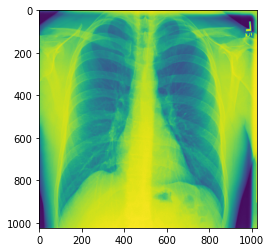

In [25]:
plt.imshow(dicom_obj.pixel_array);dicom_obj.pixel_array.shape


> Dicom files also hold metadata information. Lets look at some of the attributes, but not use it for now. If required we will use it later. 

In [26]:
meta_data = [(o.keyword,o.value) for o in dicom_obj]

In [27]:
meta_data[:5]

[('SpecificCharacterSet', 'ISO_IR 100'),
 ('SOPClassUID', '1.2.840.10008.5.1.4.1.1.7'),
 ('SOPInstanceUID', '1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027'),
 ('StudyDate', '19010101'),
 ('StudyTime', '000000.00')]

### Save images and masks as png files in seperate directory. Doing so helps in using a lot library functions easily. 

> Converting the data into the format that we are most comfortable step is highly underated.

In [28]:
img_path = (data_path/'train/images')
mask_path = (data_path/'train/mask')

img_path.mkdir(parents=True, exist_ok=True)
mask_path.mkdir(parents=True, exist_ok=True)

In [29]:
def save_dcm_png(file,dst_path):
    """Extracts image from DCM file and saves it as a PNG file in the given path"""
    fname = file.stem
    pyds = pydicom.dcmread(file)
    img = Image.fromarray(pyds.pixel_array)
    img.save(f'{dst_path}/{fname}.png')
    

In [30]:
def get_rle_mask(df,fname):
    """Converts mask from rle format to PIL Image format"""
    mask = np.zeros((1024,1024)) #Images are of size 1024*1024
    rles = df[df['ImageId']==fname]['EncodedPixels']
    for rle in rles:
        rle = rle.strip()
        if rle != "-1":
            mask += run_length_decode(rle)
    mask = mask.clip(0,1).astype(np.uint8) * 255
    mask = Image.fromarray(mask)
    return mask
    
    

In [31]:
train_meta[train_meta.ImageId == train_files[6].stem]

,ImageId,EncodedPixels
1867,1.2.276.0.7230010.3.1.4.8323329.10005.1517875220.958951,209126 1 1019 6 1015 10 1012 13 1010 14 1008 16 1007 16 1006 18 1004 20 1003 20 1002 22 1001 22 1001 23 999 24 999 24 999 25 997 26 997 27 996 27 996 27 996 28 995 28 995 28 995 29 994 29 994 30 993 30 993 30 993 31 992 31 992 31 992 32 991 32 992 32 991 33 990 33 990 33 991 33 990 33 990 33 990 34 990 33 990 34 989 35 988 35 989 35 988 35 989 35 988 35 989 34 989 35 989 34 989 34 989 35 989 34 989 35 988 36 988 35 988 35 989 35 989 34 989 34 990 34 989 34 990 34 989 34 990 34 989 34 990 34 990 34 989 34 990 33 990 34 990 33 991 32 991 33 991 32 992 32 991 33 991 32 992 32 991 32 992 32 9...


In [32]:
train_meta[train_meta['ImageId']==train_files[6].stem]['EncodedPixels']

1867     209126 1 1019 6 1015 10 1012 13 1010 14 1008 16 1007 16 1006 18 1004 20 1003 20 1002 22 1001 22 1001 23 999 24 999 24 999 25 997 26 997 27 996 27 996 27 996 28 995 28 995 28 995 29 994 29 994 30 993 30 993 30 993 31 992 31 992 31 992 32 991 32 992 32 991 33 990 33 990 33 991 33 990 33 990 33 990 34 990 33 990 34 989 35 988 35 989 35 988 35 989 35 988 35 989 34 989 35 989 34 989 34 989 35 989 34 989 35 988 36 988 35 988 35 989 35 989 34 989 34 990 34 989 34 990 34 989 34 990 34 989 34 990 34 990 34 989 34 990 33 990 34 990 33 991 32 991 33 991 32 992 32 991 33 991 32 992 32 991 32 992 32 9...
Name: EncodedPixels, dtype: object

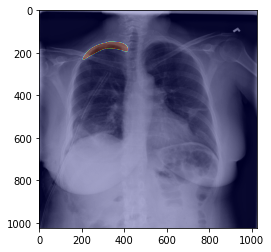

In [33]:
plt.imshow(pydicom.read_file(train_files[6]).pixel_array,cmap='gray')
plt.imshow(get_rle_mask(train_meta,train_files[6].stem),cmap='jet',alpha=0.3)

In [34]:
def save_rle_mask(df,fname,dst_path):
    mask = get_rle_mask(df,fname)
    mask.save(f'{dst_path}/{fname}.png')

Sequential approach which could take close to 1 hour.

```
for file in progress_bar(train_files):
    save_dcm_png(file,data_path/'train/images/')
    save_rle_mask(train_meta,file.stem,data_path/'train/mask/')
    
```

In [35]:
def setup(file):
    save_dcm_png(file,data_path/'train/images/')
    save_rle_mask(train_meta,file.stem,data_path/'train/mask/')

In [36]:
from fastcore.parallel import parallel

In [37]:
#Lets make it faster by using all the cores.

parallel(setup, train_files, n_workers=7, progress=True)

(#10675) [None,None,None,None,None,None,None,None,None,None...]

In [38]:
trn_images_path = (data_path/'train/images')
trn_masks_path = (data_path/'train/mask')


> It is always a good practice to do some basic checks like count match to ensure things worked as expected.

In [39]:
assert len(trn_images_path.ls()),annotated_images
assert len(trn_masks_path.ls()),annotated_images


In [40]:
def plt_img_mask(img,msk):
    plt.imshow(img,cmap='gray')
    plt.imshow(msk,cmap='jet',alpha=0.3)

In [41]:
idx = 28
img = Image.open(trn_images_path.ls()[idx])
msk = Image.open(trn_masks_path.ls()[idx])

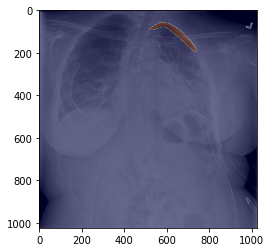

In [42]:
plt_img_mask(img,msk)

A quick way to pick an index which contains a image with Pneumotherax

In [43]:
[i for i,o in enumerate(trn_masks_path.ls()[:30]) if np.array(Image.open(o)).sum()>0]

[5, 13, 16, 18, 28]